<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Training_EE_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("completed")

completed


Cell 2: Load and Select Columns

In [14]:
# Danh sách các cột cần đọc từ autos.csv
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated'
]

# Đọc dữ liệu từ file autos.csv
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

# Xem 5 dòng đầu tiên
print("5 dòng đầu tiên của dataset:")
print(data.head())

# Thông tin dataset
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price  yearOfRegistration    gearbox  powerPS  model  kilometer  \
0    480                1993    manuell        0   golf     150000   
1  18300                2011    manuell      190    NaN     125000   
2   9800                2004  automatik      163  grand     125000   
3   1500                2001    manuell       75   golf     150000   
4   3600                2008    manuell       69  fabia      90000   

   monthOfRegistration       brand          dateCreated  
0                    0  volkswagen  2016-03-24 00:00:00  
1                    5        audi  2016-03-24 00:00:00  
2                    8        jeep  2016-03-14 00:00:00  
3                    6  volkswagen  2016-03-17 00:00:00  
4                    7       skoda  2016-03-31 00:00:00  

Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------           

Cell 3: Data Preprocessing

This cell handles missing values, caps outliers, and normalizes numerical features.

In [15]:
# Thay giá trị thiếu bằng giá trị hợp lý
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')

# Trích xuất năm từ dateCreated và tạo car_age
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data = data.drop(columns=['dateCreated', 'yearOfRegistration'])

# Đảm bảo các cột phân loại là chuỗi
data['brand'] = data['brand'].astype(str)
data['model'] = data['model'].astype(str)
data['gearbox'] = data['gearbox'].astype(str)

# Tạo biến dummy cho gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'])
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Danh sách cột số
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model']]

# Debug: Check price distribution before clipping
print("Price distribution before clipping:")
print(data['price'].describe())

# Lọc các giá trị price = 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Lọc outliers bằng percentile clipping
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Debug: Check price distribution after clipping
print("Price distribution after clipping:")
print(data['price'].describe())

# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Chuẩn hóa price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

# Xem dữ liệu sau xử lý
print("\n5 dòng đầu tiên sau khi xử lý outliers và chuẩn hóa:")
print(data.head())

# Thông tin dataset sau xử lý
print("\nThông tin dataset sau xử lý:")
print(data.info())

Price distribution before clipping:
count    3.715280e+05
mean     1.729514e+04
std      3.587954e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
max      2.147484e+09
Name: price, dtype: float64
Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Price distribution after clipping:
count    360750.000000
mean       5681.355529
std        6807.173738
min         110.000000
25%        1250.000000
50%        3000.000000
75%        7490.000000
max       36500.000000
Name: price, dtype: float64


<ipython-input-15-8ada02f6c21b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-15-8ada02f6c21b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-15-8ada02f6c21b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý outliers và chuẩn hóa:
      price   powerPS    model  kilometer  monthOfRegistration       brand  \
0  0.010168  0.203390     golf   1.000000             0.454545  volkswagen   
1  0.499863  0.491525  unknown   0.827586             0.363636        audi   
2  0.266282  0.400000    grand   0.827586             0.636364        jeep   
3  0.038197  0.101695     golf   1.000000             0.454545  volkswagen   
4  0.095905  0.081356    fabia   0.586207             0.545455       skoda   

   adYear   car_age  automatik  manual  manuell  
0     1.0  0.641026        0.0     0.0      1.0  
1     1.0  0.179487        0.0     0.0      1.0  
2     1.0  0.358974        1.0     0.0      0.0  
3     1.0  0.435897        0.0     0.0      1.0  
4     1.0  0.256410        0.0     0.0      1.0  

Thông tin dataset sau xử lý:
<class 'pandas.core.frame.DataFrame'>
Index: 360750 entries, 0 to 371527
Data column

Cell 4: Train-Test Split

This cell splits the data into training, validation (tune), and test sets.

In [16]:
# Đặc trưng
X = data.drop(['price'], axis=1).copy()
# Mục tiêu
y = data['price']

# Chia tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chia tập train thành train và validation
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Debug: Check the range of y_train and y_test
print("y_train range (should be normalized [0, 1]):", y_train.min(), y_train.max())
print("y_test range (should be normalized [0, 1]):", y_test.min(), y_test.max())

# Kiểm tra số bản ghi
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')

y_train range (should be normalized [0, 1]): 0.0 1.0
y_test range (should be normalized [0, 1]): 0.0 1.0

Tập huấn luyện có 230880 bản ghi và 10 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Encode Categorical Variables for Embedding

This cell encodes categorical variables as integers for use in embedding layers.

In [17]:
# Danh sách đầu vào cho tập train, validation, và test
input_list_train_new = []
input_list_val = []
input_list_test = []

# Mã hóa biến phân loại (brand và model)
cat_encoders = {}
for col in ['brand', 'model']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

# Danh sách cột số (bao gồm dummy variables)
numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model']]

# Thêm giá trị số vào danh sách đầu vào
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

# Chuyển y sang float32
y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Debug: Check the range of y_test after conversion
print("y_test range after conversion (should be normalized [0, 1]):", y_test.min(), y_test.max())


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.
y_test range after conversion (should be normalized [0, 1]): 0.0 1.0


Cell 6: Define Embedding Dimensions

This cell calculates embedding dimensions dynamically based on the number of unique categories.


Tóm tắt mô hình MLP:


Model: "Best_EE_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_brand           │ (None, 1, 5)           │            200 │ input_layer_3[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_model           │ (None, 1, 10)          │          2,500 │ input_layer_4[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 5)              │              0 │ embedding_brand[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 10)             │              0 │ embedding_model[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 23)             │              0 │ reshape_2[0][0],       │
│ (Concatenate)             │                        │                │ reshape_3[0][0],       │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │          3,072 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64)             │            256 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dropout_3[0][0]        │
├──────────────────────

 Total params: 17,549 (68.55 KB)

 Trainable params: 17,101 (66.80 KB)

 Non-trainable params: 448 (1.75 KB)

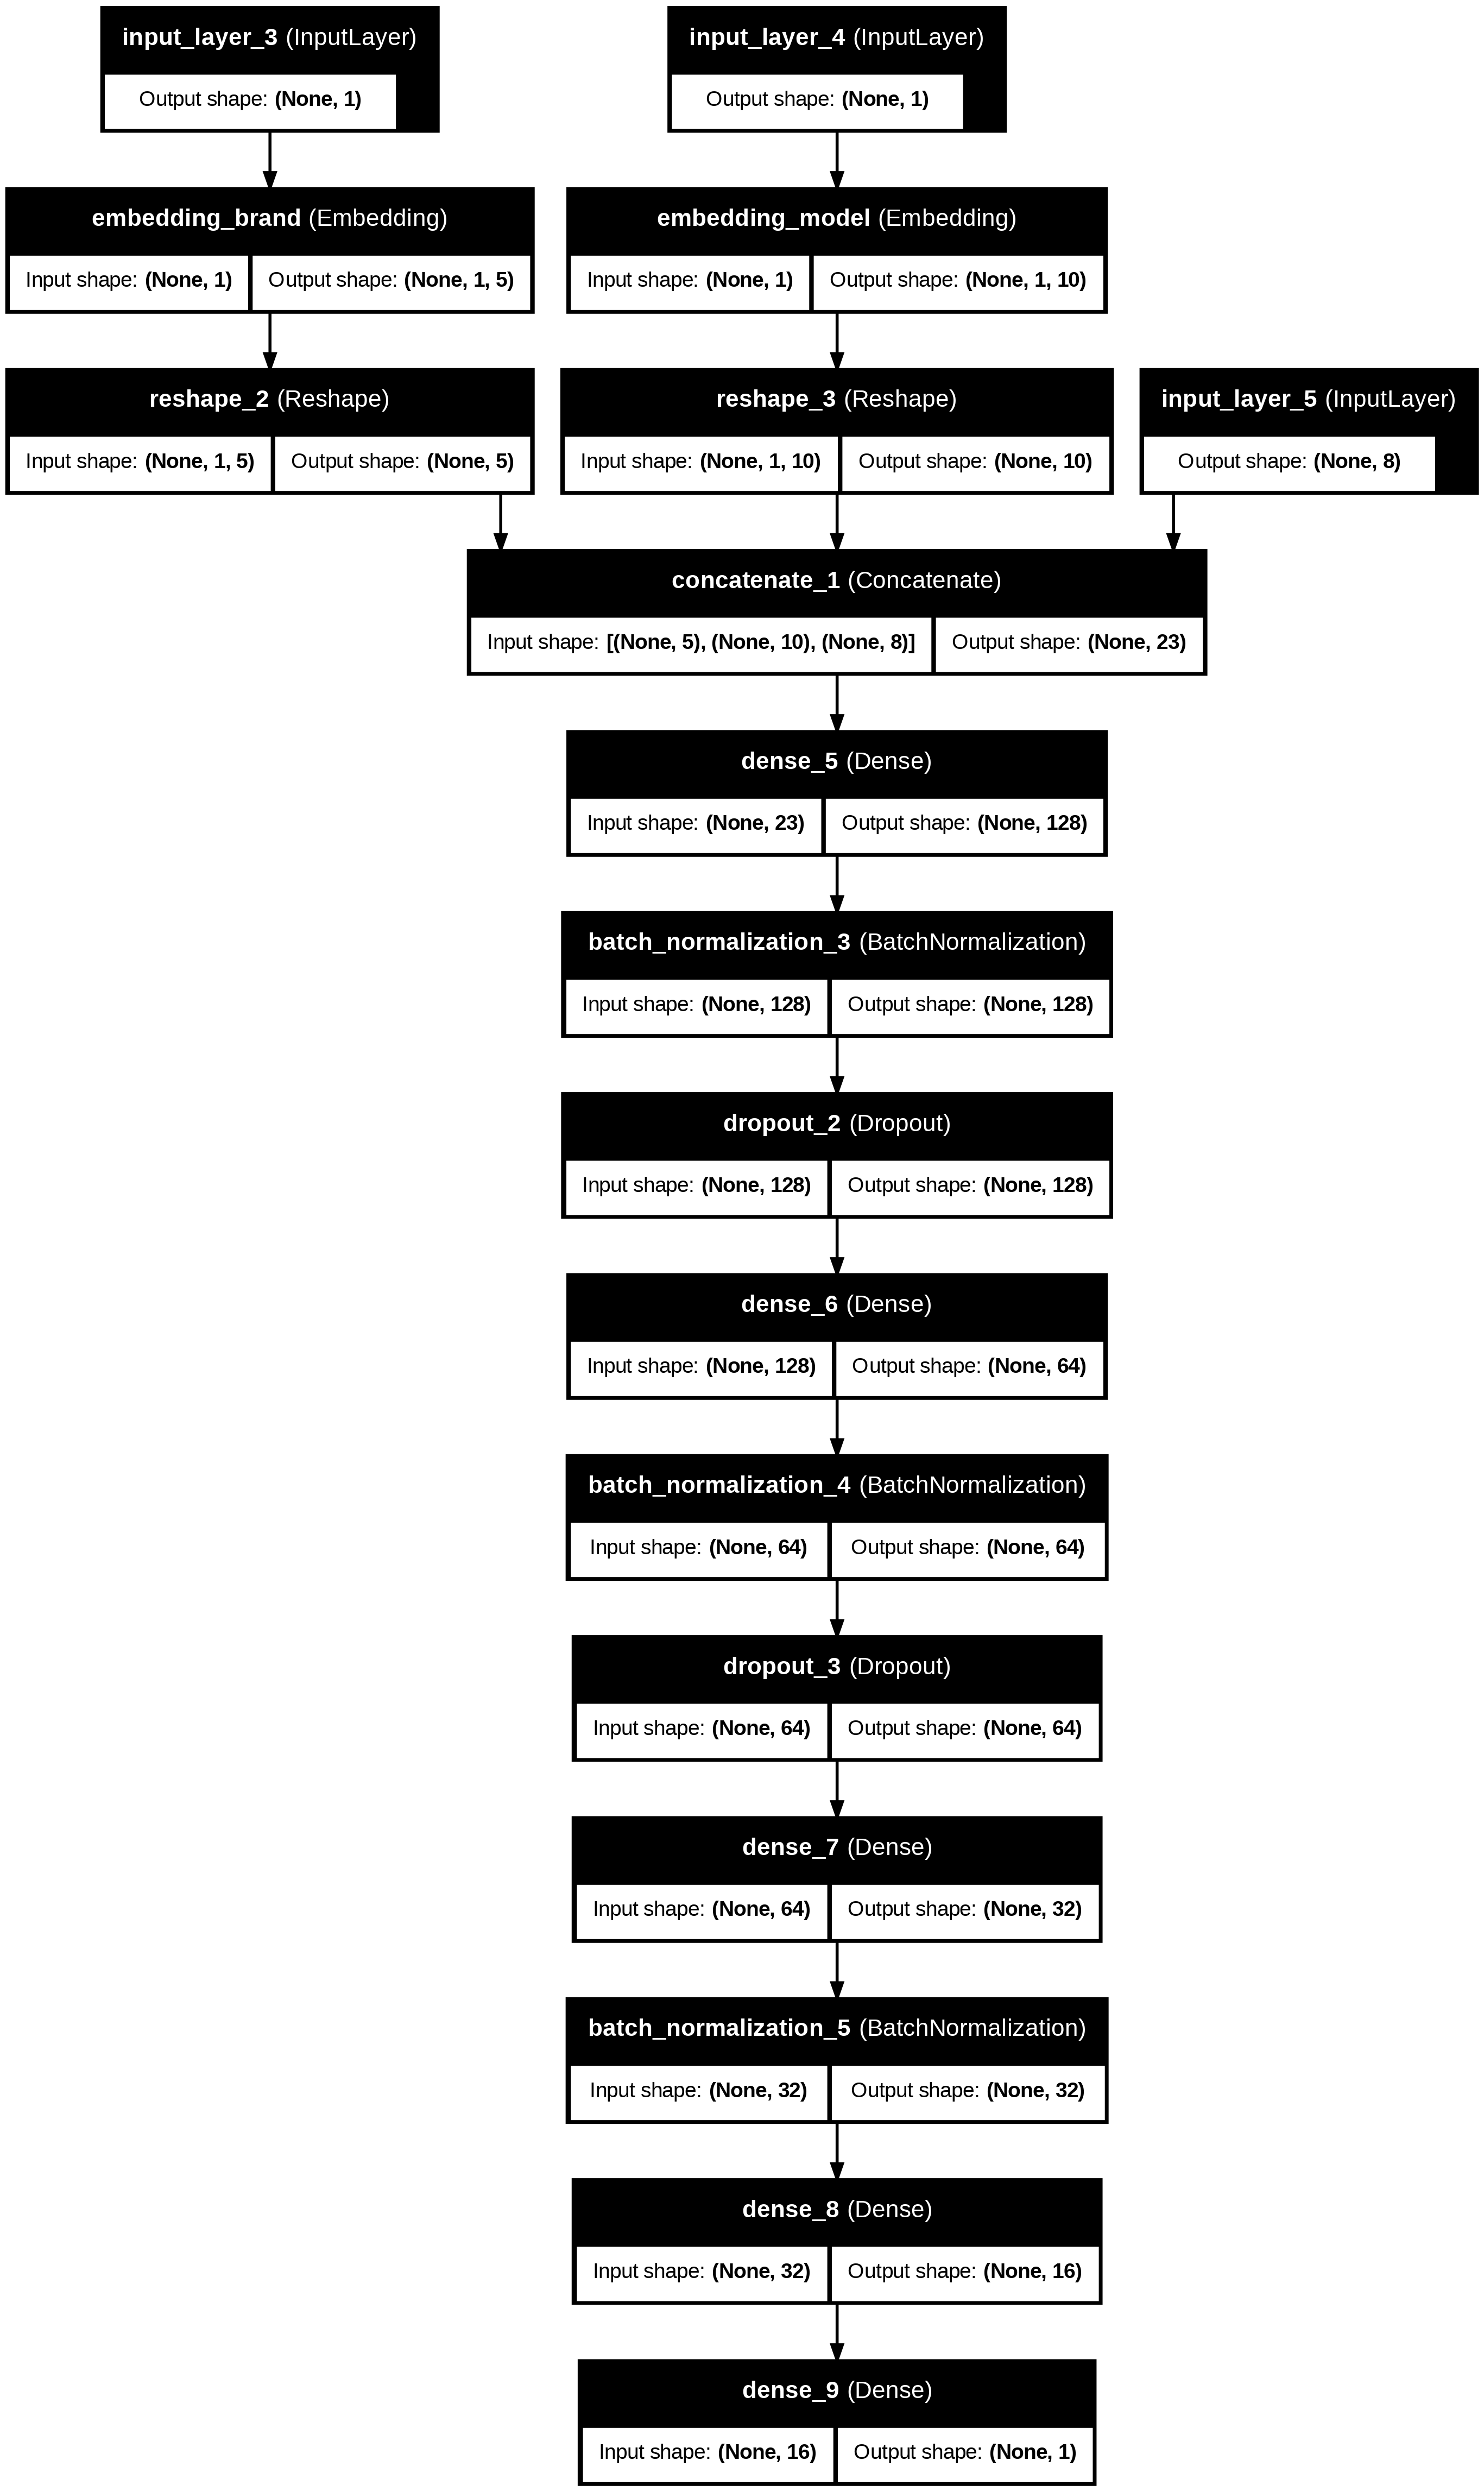

In [18]:
# Số giá trị duy nhất trong cột brand và model
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))

# Đầu vào và embedding cho brand
input_brand = Input(shape=(1,))
brand_emb_dim = 5
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=brand_emb_dim, name="embedding_brand")(input_brand)
emb_brand = Reshape(target_shape=(brand_emb_dim,))(emb_brand)

# Đầu vào và embedding cho model
input_model = Input(shape=(1,))
model_emb_dim = 10
emb_model = Embedding(input_dim=n_unique_model, output_dim=model_emb_dim, name="embedding_model")(input_model)
emb_model = Reshape(target_shape=(model_emb_dim,))(emb_model)

# Đầu vào cho biến số
input_numeric = Input(shape=(len(numeric_cols),))
emb_numeric = input_numeric

# Danh sách đầu vào và embedding
input_data = [input_brand, input_model, input_numeric]
emb_data = [emb_brand, emb_model, emb_numeric]

# Ghép các embedding
model_data = Concatenate()(emb_data)

# Kiến trúc MLP với L2 regularization và BatchNormalization
model = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(model_data)
model = BatchNormalization()(model)
model = Dropout(0.2)(model)
model = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(model)
model = BatchNormalization()(model)
model = Dropout(0.2)(model)
model = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(model)
model = BatchNormalization()(model)
model = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(model)
outputs = Dense(1, activation='linear')(model)

# Tạo mô hình
nn = Model(inputs=input_data, outputs=outputs, name='Best_EE_MLP')

# Tóm tắt mô hình
print("\nTóm tắt mô hình MLP:")
nn.summary()

# Vẽ cấu trúc mô hình
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Best_EE_MLP.png')
Image(retina=True, filename='Best_EE_MLP.png')

Cell 7: Build and Compile the MLP Model with Entity Embeddings

Epoch 1/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.9854 - mae: 0.1850 - val_loss: 0.0376 - val_mae: 0.0788 - learning_rate: 0.0010
Epoch 2/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0211 - mae: 0.0585 - val_loss: 0.0116 - val_mae: 0.0587 - learning_rate: 0.0010
Epoch 3/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0102 - mae: 0.0530 - val_loss: 0.0118 - val_mae: 0.0652 - learning_rate: 0.0010
Epoch 4/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0097 - mae: 0.0522 - val_loss: 0.0094 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 5/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0096 - mae: 0.0518 - val_loss: 0.0089 - val_mae: 0.0487 - learning_rate: 0.0010
Epoch 6/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0096 - mae: 0.0519 - val_loss: 0.0087 - val_mae: 0.0481 - learning_rate: 0.0010
Epoch 7/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0093 - mae: 0.0516 - val_loss: 0.0141 - val_mae: 0.0723 - learning_rate: 0.00

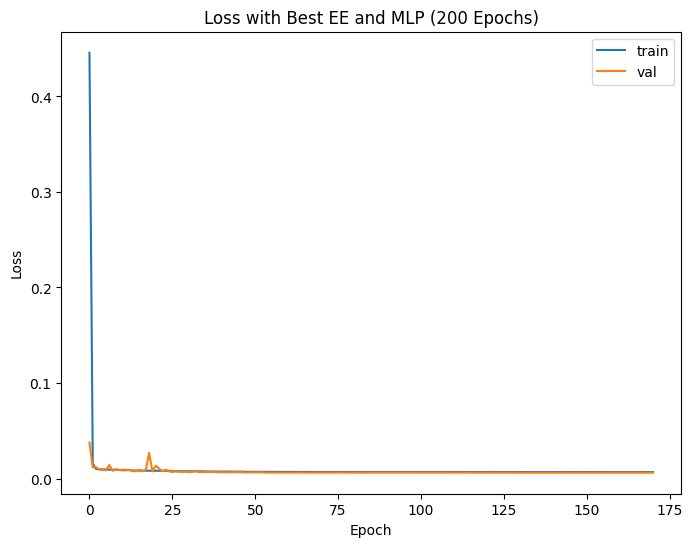

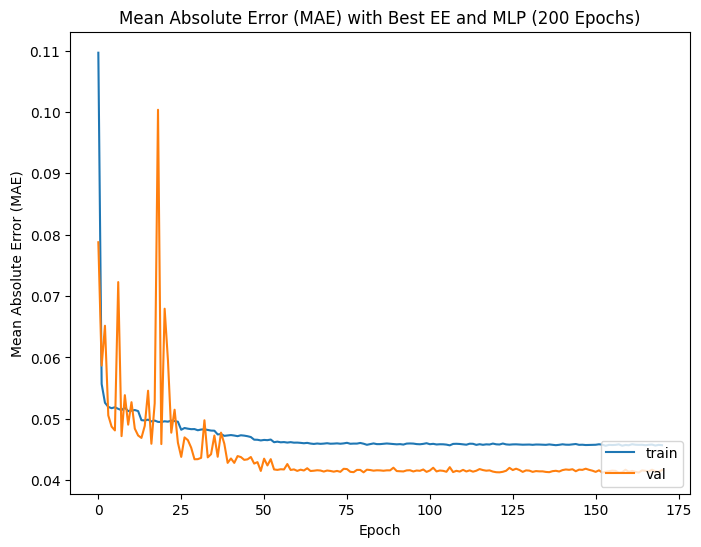

In [19]:
# Biên dịch mô hình
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

# Thiết lập early stopping và learning rate scheduler
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Huấn luyện mô hình
history = nn.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Vẽ biểu đồ loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Best EE and MLP (200 Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Vẽ biểu đồ MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Best EE and MLP (200 Epochs)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 8: Train the Model

Price Scaler Parameters in Cell 8:
data_min_: [110.]
data_max_: [36500.]
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
y_test_predict (normalized) range: 0.0009933673 1.0676495
y_test (normalized) range: 0.0 1.0
y_test_predict (original scale) range: 146.14864 38961.766
y_test (original scale) range: 109.99999 36500.0
Number of zeros in Actual: 0


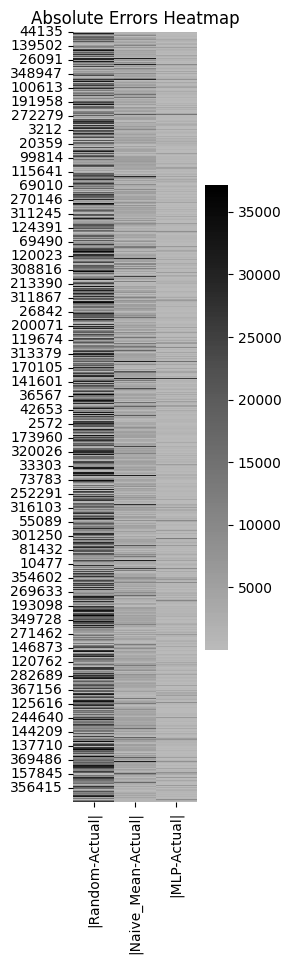

Evaluation Metrics:
            Random   Naive_Mean          MLP
ME   -12579.095947     28.46044   -11.456895
RMSE  17759.757069  6834.731936  2691.701416
MAE   14736.830009  4830.548835  1492.650146
MAPE   1280.776991   352.496561    91.470959


In [20]:
# Debug: Check price_scaler parameters before inverse transform
print("Price Scaler Parameters in Cell 8:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

# Generate predictions on the test set
y_test_predict = nn.predict(input_list_test)

# Debug: Check the range of y_test_predict before inverse transform
print("y_test_predict (normalized) range:", y_test_predict.min(), y_test_predict.max())

# Check if y_test is normalized; if not, normalize it
if y_test.max() > 1.0 or y_test.min() < 0.0:
    print("y_test is not normalized! Re-normalizing...")
    y_test = (y_test - price_scaler.data_min_[0]) / (price_scaler.data_max_[0] - price_scaler.data_min_[0])
print("y_test (normalized) range:", y_test.min(), y_test.max())

# Chuyển đổi ngược dự đoán và giá trị thực về thang ban đầu
y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Debug: Check the range after inverse transform
print("y_test_predict (original scale) range:", y_test_predict.min(), y_test_predict.max())
print("y_test (original scale) range:", y_test.min(), y_test.max())

# Tạo DataFrame kết quả
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'Actual'])
result_df['Actual'] = y_test

# Baseline: Naive Mean
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()

# Baseline: Random
result_df['Random'] = np.random.uniform(y_train.min(), y_train.max(), len(y_test))
result_df['Random'] = price_scaler.inverse_transform(result_df['Random'].values.reshape(-1, 1)).flatten()

# MLP Prediction
result_df['MLP'] = y_test_predict.flatten()

# Debug: Check for zeros in Actual
print("Number of zeros in Actual:", (result_df['Actual'] == 0).sum())

# Tính sai số tuyệt đối
for m in ['Random', 'Naive_Mean', 'MLP']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

# Heatmap
table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()

# Tính toán các chỉ số đánh giá
metric_df = pd.DataFrame(index=['ME', 'RMSE', 'MAE', 'MAPE'],
                         columns=['Random', 'Naive_Mean', 'MLP'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['ME', m] = np.sum(result_df['Actual'] - result_df[m]) / n_test
    metric_df.at['RMSE', m] = np.sqrt(np.sum((result_df['Actual'] - result_df[m])**2) / n_test)
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    # Avoid division by zero in MAPE
    non_zero_mask = result_df['Actual'] != 0
    if non_zero_mask.sum() > 0:
        metric_df.at['MAPE', m] = np.sum(abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / result_df['Actual'][non_zero_mask]) / non_zero_mask.sum() * 100
    else:
        metric_df.at['MAPE', m] = np.nan

print("Evaluation Metrics:")
print(metric_df)

**Cell** 8: re-analyze

Price Scaler Parameters in Cell 8:
data_min_: [110.]
data_max_: [36500.]
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
y_test_predict (normalized) range: 0.0009933673 1.0676495
y_test is not normalized! Re-normalizing...
y_test (normalized) range: -2.0965634875652653e-10 1.0
y_test_predict (original scale) range: 146.14864 38961.766
y_test (original scale) range: 109.99999237060547 36500.0
Number of zeros in Actual: 0
Evaluation Metrics:
               Random       Naive_Mean             MLP
MSE   313587007.28306  46713560.642554  7245256.117666
RMSE     17708.388049      6834.731936     2691.701343
MAE      14682.904943      4830.548835     1492.650164
R2          -5.713092        -0.000017        0.844898
MAPE       741.999184       192.844377       45.600247


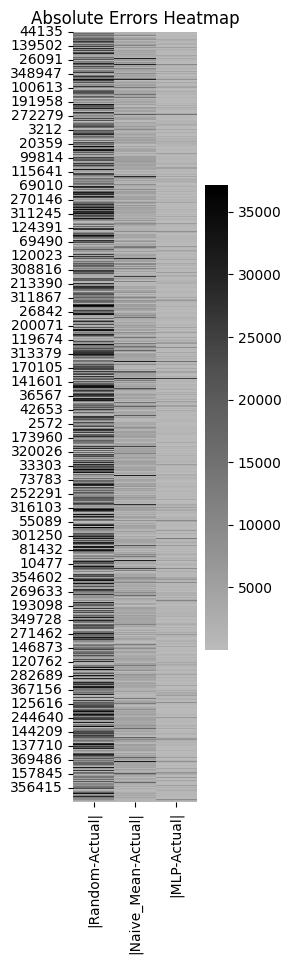

In [21]:
# Debug: Check price_scaler parameters before inverse transform
print("Price Scaler Parameters in Cell 8:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

# Generate predictions on the test set
y_test_predict = nn.predict(input_list_test)

# Debug: Check the range of y_test_predict before inverse transform
print("y_test_predict (normalized) range:", y_test_predict.min(), y_test_predict.max())

# Check if y_test is normalized; if not, normalize it
if y_test.max() > 1.0 or y_test.min() < 0.0:
    print("y_test is not normalized! Re-normalizing...")
    y_test = (y_test - price_scaler.data_min_[0]) / (price_scaler.data_max_[0] - price_scaler.data_min_[0])
print("y_test (normalized) range:", y_test.min(), y_test.max())

# Chuyển đổi ngược dự đoán và giá trị thực về thang ban đầu
y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Debug: Check the range after inverse transform
print("y_test_predict (original scale) range:", y_test_predict.min(), y_test_predict.max())
print("y_test (original scale) range:", y_test.min(), y_test.max())

# Tạo DataFrame kết quả
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'Actual'])
result_df['Actual'] = y_test

# Baseline: Naive Mean
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()

# Baseline: Random
result_df['Random'] = np.random.uniform(y_train.min(), y_train.max(), len(y_test))
result_df['Random'] = price_scaler.inverse_transform(result_df['Random'].values.reshape(-1, 1)).flatten()

# MLP Prediction
result_df['MLP'] = y_test_predict.flatten()

# Debug: Check for zeros in Actual
print("Number of zeros in Actual:", (result_df['Actual'] == 0).sum())

# Tính toán các chỉ số đánh giá
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'MAE', 'R2', 'MAPE'],
                         columns=['Random', 'Naive_Mean', 'MLP'])
n_test = len(result_df)

for m in metric_df.columns:
    # MSE
    metric_df.at['MSE', m] = np.sum((result_df['Actual'] - result_df[m])**2) / n_test
    # RMSE
    metric_df.at['RMSE', m] = np.sqrt(metric_df.at['MSE', m])
    # MAE
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    # R²
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    # MAPE (with a minimum denominator to avoid inflation from small actual values)
    non_zero_mask = result_df['Actual'] != 0
    if non_zero_mask.sum() > 0:
        # Use a minimum denominator of 1000 to prevent small actual values from inflating MAPE
        metric_df.at['MAPE', m] = np.sum(np.abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / np.maximum(result_df['Actual'][non_zero_mask], 1000)) / non_zero_mask.sum() * 100
    else:
        metric_df.at['MAPE', m] = np.nan

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of Absolute Errors
for m in ['Random', 'Naive_Mean', 'MLP']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()

Cell 10: Tune the Model

Tests different hidden layer sizes and reports RMSE on the validation set.

In [ ]:
# # Tuning hidden layer sizes
# hidden_layer_options = [(128, 64, 32), (64, 32), (256, 128, 64)]
# tune_df = pd.DataFrame(index=[str(h) for h in hidden_layer_options], columns=['RMSE'])

# for h in hidden_layer_options:
#     # Model building and training code (abridged)
#     # ...
#     y_tune_predict = model.predict(input_list_tune)
#     rmse = np.sqrt(np.mean((price_scaler.inverse_transform(y_tune_predict) -
#                             price_scaler.inverse_transform(y_tune.values.reshape(-1, 1)))**2))
#     tune_df.at[str(h), 'RMSE'] = rmse

# print("Tuning Results:")
# print(tune_df.sort_values('RMSE'))